# Introduction 

This notebook was used for building the random forest classifier with molecular descriptors (MD) in the “Random forest classification for predicting lifespan-extending chemical compounds” paper.

Please run in Python 3.

In [1]:
import numpy as np
import pandas as pd

#splitting data into train and test, cross-validation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict

#removing variance
from sklearn.feature_selection import VarianceThreshold

#Random Forest
from sklearn.ensemble import RandomForestClassifier
import statistics
import math
import random 

#Adjusted Mutual Information
from sklearn.metrics.cluster import adjusted_mutual_info_score

#visualisation
import seaborn as sns
import matplotlib.pylab as plt

#PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# confusion matrix, AUC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics


In [2]:
# import data

data = pd.read_csv("../data/df_descriptors.csv", encoding = "ISO-8859-1")
display(data.head())
print("number of compounds:", data.shape[0], ", number of features:", data.shape[1])

,Standardised_Smiles,AM1_E,AM1_Eele,AM1_HF,AM1_HOMO,AM1_IP,AM1_LUMO,AM1_dipole,ASA,ASA+,...,vsurf_Wp3,vsurf_Wp4,vsurf_Wp5,vsurf_Wp6,vsurf_Wp7,vsurf_Wp8,weinerPath,weinerPol,zagreb,Target
0,Oc1c(Cl)cc(Cl)cc1Sc1cc(Cl)cc(Cl)c1O,-91061.594,-490900.38,-54.180599,-9.08072,9.08072,-0.86114,1.984315,493.96982,116.66142,...,59.125,3.750,0.75,0.000,0.000,0.0,688,30,98,0
1,CCCCCC1C(=O)CCC1CC(=O)O,-64010.746,-377504.44,-181.891950,-10.37975,10.37975,0.76110,1.842890,458.93463,320.75201,...,31.375,6.625,2.75,0.625,0.125,0.0,400,17,68,0
2,Cc1cc(=O)n(-c2ccccc2)n1C,-53151.840,-302296.66,64.051399,-8.76044,8.76044,-0.17180,4.432582,392.48480,232.39806,...,16.000,0.000,0.00,0.000,0.000,0.0,284,20,72,0
3,O=C(C=CC=Cc1ccc2c(c1)OCO2)N1CCCCC1,-83131.195,-527420.63,-51.748039,-8.66869,8.66869,-0.80507,2.895411,548.17822,370.79236,...,20.000,0.000,0.00,0.000,0.000,0.0,1131,27,106,0
4,O=c1ccc2cc(OC3OC(CO)C(O)C(O)C3O)c(O)cc2o1,-115882.230,-774507.50,-348.088130,-9.29644,9.29644,-1.18028,4.948146,522.75287,310.44724,...,94.625,18.375,4.75,0.625,0.000,0.0,1339,42,128,0


number of compounds: 1430 , number of features: 356


In [3]:
# define X (features) and y (target)
X = data.iloc[:, 1:-1]
y = data.iloc[:, -1]

# Chemical Space Visualisation

In [4]:
# standardize features for PCA
descriptors_std = StandardScaler().fit_transform(X)

In [5]:
pca = PCA(n_components=2)
res = pca.fit_transform(descriptors_std)
print(res.shape)

(1430, 2)


In [6]:
principal = pd.DataFrame(data = res, columns = ['PC_1', 'PC_2'])

finalPCA = pd.concat([principal,  data[['Target']]], axis = 1)
display(finalPCA.head())

,PC_1,PC_2,Target
0,-2.815871,-3.917015,0
1,-4.978448,-0.271778,0
2,-8.871983,-4.891291,0
3,-1.270698,-6.003349,0
4,3.756103,10.166345,0


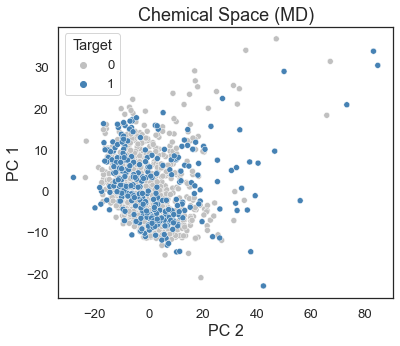

In [7]:
sns.set(rc={'figure.figsize':(6, 5)}, font_scale = 1.2)
sns.set_style("white")


colours = 'silver', 'steelblue'

ax = sns.scatterplot(data=finalPCA, x='PC_1', y='PC_2', hue = 'Target', palette= colours)

plt.ylabel('PC 1',fontsize=16)
plt.xlabel('PC 2',fontsize=16)
plt.title('Chemical Space (MD)', fontsize= 18)
        
plt.show()

# Data Pre-Processing

### Creating Training and Test Set 

In [8]:
# split dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 1)
print("X_train:{}".format(X_train.shape))
print("y_train:{}".format(y_train.shape), "\n")
print("X_test:{}".format(X_test.shape))
print("y_test:{}".format(y_test.shape))

X_train:(1144, 354)
y_train:(1144,) 

X_test:(286, 354)
y_test:(286,)


### Remove variance

In [9]:
# function for removing features with low variance
def get_variance(df, threshold):
    sel = VarianceThreshold(threshold = (threshold))
    var_norm = sel.fit_transform(X_train)
    features = sel.get_support(indices = True) 
    colname = X_train.columns[features]
    var = pd.DataFrame(data = var_norm)
    var.columns = colname
    return (var)

In [10]:
# creating three subdatabases which removes features with (i) 100% (ii) 95% and (iii) 90% constant values
X_var_100 = get_variance(X_train,1 *(1- 1))
X_var_95 = get_variance(X_train, 0.95 *(1- 0.95))
X_var_90 = get_variance(X_train, 0.90 *(1- 0.90))

display("X_var_100: {}".format(X_var_100.shape))
display("X_var_95: {}".format(X_var_95.shape))
display("X_var_90: {}".format(X_var_90.shape))

'X_var_100: (1144, 349)'

'X_var_95: (1144, 289)'

'X_var_90: (1144, 277)'

# Feature Selection

In [11]:
# function for sorting features based on highest adjusted mutual information scores with target
def highest_ami(X_var, percentage): 
    
    # initiate empty list to store adjusted mutual information (ami) values
    ami = []
    
    # calculate ami score between each feature and target
    for v in range (0, X_var.shape[1]):
        ami.append(adjusted_mutual_info_score(X_var.iloc[:, v], y_train, average_method= "arithmetic"))

    # sort ami scores in descending order
    ami_sorted= sorted([(x,i) for (i,x) in enumerate(ami)], reverse=True)
    # extract feature ids
    ami_feature_ids = [ami_sorted[i][1] for i in range(0, len(ami_sorted))]

    # return percentage of features with highest ami values
    m = round(X_var.shape[1]*percentage)
    features = ami_feature_ids[:m]
    X_selected = X_var.iloc[:, features]
    
    return(X_selected)

In [12]:
# ignore warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# initiate empty lists to store ami values for var_100, var_95 and var_90
var_100= []
var_95= []
var_90= []

# Create total of 18 sub-databases consisting of 5%, 10%, 25%, 50%, 75% and 100% of the features with the highest AMI score for each of Var_100, Var_95 and Var_90
for i in (0.05, 0.1, 0.25, 0.5, 0.75, 1):
    var_100.append(highest_ami(X_var_100, i))
    var_95.append(highest_ami(X_var_95, i))
    var_90.append(highest_ami(X_var_90, i))

## Cross-validation

In [13]:
def cross_validation (num_splits, X, y, n_estimators =100, random_state =1):
    
    # initiate stratified k-fold cross validation
    sfk = StratifiedKFold(n_splits = num_splits, shuffle=True, random_state= random_state)
    
    #  initiate random forest classifier with balanced class weights (remaining parameters are default settings) 
    rf = RandomForestClassifier(n_estimators = n_estimators, random_state= random_state, 
                                class_weight = 'balanced')
    # perform cross-validation and get area under the ROC curve scores
    rfc_cv_score = cross_val_score(rf, X, y, cv= sfk, scoring='roc_auc')

    return (rfc_cv_score)

In [14]:
# perform 10 fold cross-validation
var_100_mi = []
var_95_mi = []
var_90_mi = []

for i in range (0, 6):
    var_100_mi.append(cross_validation (10, var_100[i], y_train))
    var_95_mi.append(cross_validation (10,  var_95[i], y_train))
    var_90_mi.append(cross_validation (10, var_90[i], y_train))

## Heatmap

In [15]:
def heatmap(var, name1,name2, name3):
    var_hm = pd.DataFrame(data = var)
    # calculate median auc score and standard deviation for each fold of the 10-fold cross-validation
    data_hm = pd.concat([var_hm.T.median(), var_hm.T.std()], axis = 1).round(3)
    data_hm.columns = [name1, name2]
    data_hm.index =["5% (MD)", "10% (MD)", "25% (MD)", 
                                   "50% (MD)", "75% (MD)" , "100% (MD)"]
    
    data_hm[name3] = data_hm[name1].map(str) + str(" +/- ") + data_hm[name2].map(str)
    return(data_hm.round(3))

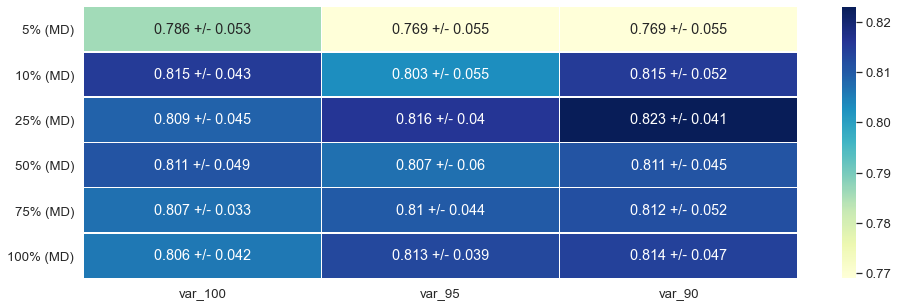

In [16]:
# get list of median auc score and stdev of the 10-fold cross-validation for each of the 18 sub-databases
var_100_hm = heatmap(var_100_mi, "var_100","var_100_std", "var_100_all")
var_95_hm = heatmap(var_95_mi, "var_95","var_95_std", "var_95_all")
var_90_hm = heatmap(var_90_mi, "var_90","var_90_std", "var_90_all")

data_hm = pd.concat([var_100_hm, var_95_hm, var_90_hm], axis = 1)

# generate heatmap
sns.set(rc={'figure.figsize':(16,5)}, font_scale = 1.2)

ax = sns.heatmap(data_hm.iloc[:, [0,3,6]],linewidth=0.5, annot = data_hm.iloc[:, [2,5,8]], fmt = '', cmap="YlGnBu")
plt.show()

## Evaluating Model 

In [17]:
# select model with highest median auc score
colums_name= var_90[2].columns
# only use selected features in test set
X_test_features = X_test[colums_name[:]]

# initiare random forest model
rf = RandomForestClassifier(n_estimators = 100, random_state= 1, criterion='gini', class_weight = 'balanced')
# fit data
rf.fit(var_90[2], y_train)
# predict y 
y_score = rf.predict(X_test_features)
y_pred_proba = rf.predict_proba(X_test_features)[::,1]

# evaluate predictions (y predicted vs y test)
print("=== Confusion Matrix ===")
CM = confusion_matrix(y_test, y_score)
print(CM)
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_score))
print('\n')
print("=== AUC Score ===")
print(round(roc_auc_score(y_test, y_pred_proba),3))

=== Confusion Matrix ===
[[223  11]
 [ 31  21]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       234
           1       0.66      0.40      0.50        52

    accuracy                           0.85       286
   macro avg       0.77      0.68      0.71       286
weighted avg       0.84      0.85      0.84       286



=== AUC Score ===
0.815


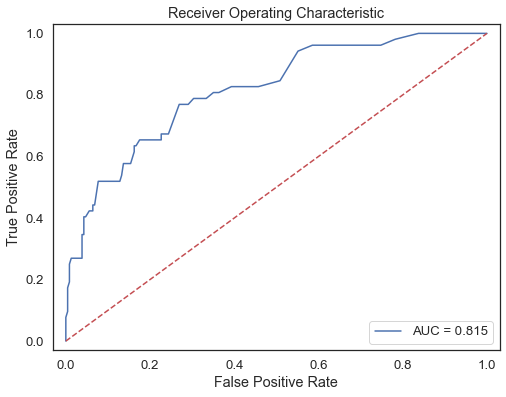

In [18]:
sns.set(rc={'figure.figsize':(8,6)}, font_scale = 1.2)
sns.set_style("white")

y_pred_proba = rf.predict_proba(X_test_features)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.03, 1.03])
plt.ylim([-0.03, 1.03])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [19]:
# get features with highest gini importance scores
feature_imp = pd.Series(rf.feature_importances_,index=colums_name).sort_values(ascending=False)
round(feature_imp.head(30), 3)

a_nN             0.062
PEOE_VSA+2       0.029
vsurf_D8         0.026
h_pKa            0.024
SMR_VSA6         0.023
rsynth           0.023
PEOE_VSA-4       0.022
PEOE_VSA+4       0.021
PEOE_VSA-6       0.021
PEOE_VSA_PPOS    0.021
chi0_C           0.020
Q_VSA_PNEG       0.020
PEOE_VSA_POL     0.020
chi0v_C          0.020
SMR_VSA3         0.019
Q_VSA_PPOS       0.019
b_single         0.018
a_count          0.018
SlogP_VSA3       0.018
PEOE_VSA_PNEG    0.018
TPSA             0.017
zagreb           0.017
weinerPol        0.017
opr_brigid       0.017
Kier3            0.017
PEOE_VSA-1       0.016
chi0             0.016
Kier2            0.016
SlogP_VSA2       0.016
a_nH             0.015
dtype: float64